# Amazon Copurchased

This is a Python notebook created using "jupyter".

Author: Rafael J. P. dos Santos

## Condições do experimento

* Utilização de todas as features exceto métricas de rede
* Limite de 22934 ligações (~10% da base)

## Parameters

We use the parameter below to set the maximum number of edges to be read from the CSV containing edges (links).

In [1]:
max_edges = 500 # Set quantity to read from file
edges_csv_file = "data/20180812_links"
nodes_csv_file = "data/20180812_nodes"

## Load the libraries

Let's load the Python libraries that we will need throughout the script

In [2]:
%load_ext autoreload
%autoreload 1
%aimport shared_functions
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import export_graphviz
import pydot
from __future__ import division
import sklearn
import sys
import shared_functions
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.2.


## Read graph

### Read only first lines of datafile

Due to slowness in calculating centrality measures, we use the parameter provided in the beggining of the script to limit the number of edges we will read.

In [3]:
G = shared_functions.read_G(edges_csv_file, max_edges)

Using 500 edges out of 229338 available (0.22% of data)


### Calculate nodes centrality measures

Now that we have our NetworkX graph, let's calculate some centrality measures for every node.

In [4]:
centrality_measures = shared_functions.centrality_measures(G)

### Load node properties

Let's load the CSV containing the nodes data (title, price) into a Pandas dataframe, and append the centrality measures calculated above.

In [5]:
df = pd.read_csv(nodes_csv_file)

####  Convert ID to random int to avoid leaking knowledge

In [6]:
df = shared_functions.add_sha256_column_from_id(df)

#### Add centrality measures

In [7]:
df = shared_functions.merge_columns(df, centrality_measures)

### Let's convert some fields to numeric

In [8]:
categorical_features = [
    'category1',
    'category2',
    'category3',
    'category4',
    'category5',
    'category6',
    'category7',
    'category8',
    'category9',
    'category10',
    'language',
    'coverType',
    'publisher',
    'rankingCategory',
    'authors'
]

numeric_features = [
    #'degree',
    #'eigenvector_centrality',
    #'betweenness_centrality',
    'ranking',
    'reviewCount',
    'pages',
    'weight',
    'height',
    'width',
    'depth',
    'rating'
]

df = shared_functions.prepare_data(df, numeric_features)

### Remove nodes without price

In [9]:
df = df.drop(df[df["price"].isnull()].index)
#df = df.drop(df[df["price"] > 500].index)

### Inspect columns

In [10]:
df.columns

Index([u'id', u'title', u'url', u'authors', u'coverType', u'publisher',
       u'edition', u'publicationDate', u'rankingCategory', u'category1',
       u'category2', u'category3', u'category4', u'category5', u'category6',
       u'category7', u'category8', u'category9', u'category10', u'isbn10',
       u'isbn13', u'language', u'postProcessed', u'price', u'ranking',
       u'pages', u'reviewCount', u'rating', u'width', u'height', u'depth',
       u'weight', u'sha256_id', u'eigenvector_centrality', u'degree',
       u'betweenness_centrality'],
      dtype='object')

### Features summary

Below we have a summary of the Pandas dataframe. We can see the number of nodes that we are actually analyzing, which depends on the max_edges parameter defined before.

In [11]:
pd.set_option('display.max_columns', None)
df.describe(include='all', percentiles=[0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99])

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,sha256_id,eigenvector_centrality,degree,betweenness_centrality
count,209.000000,209,209,209,205,206,0.0,65,145,145,145,143,131,116,55,3,0.0,0.0,0.0,207,207,207,209.0,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,2.090000e+02,209.000000,209.000000,209.000000
unique,NaN,209,209,188,2,61,NaN,65,1,1,6,12,15,31,21,2,NaN,NaN,NaN,207,207,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Introduction to Differential Geometry of Space...,https://www.amazon.com.br/dp/1305272420/,"Wolfgang Pauli (Autor),",Capa comum,Dover Publications,NaN,6 de outubro de 2003,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Matemática Pura,Cálculo,Abstrata,NaN,NaN,NaN,0465054722,978-0070542341,Inglês,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,1,5,132,46,NaN,1,145,145,137,120,72,21,9,2,NaN,NaN,NaN,1,1,199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1358.755981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,304.721148,148633.914522,442.433984,5.305556,4.544444,16.480350,23.370490,2.470005,508.523240,2.056343e+09,0.042595,4.430622,0.016860
std,987.898709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,395.376513,94756.970384,248.552573,3.666139,0.320823,2.595949,2.043063,1.148541,216.617141,1.161107e+09,0.052606,10.942429,0.052275
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,23.920000,1053.000000,68.000000,1.000000,1.000000,10.000000,17.000000,0.500000,40.800000,1.612626e+07,0.000798,1.000000,0.000000
25%,300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,57.870000,78944.000000,272.000000,5.305556,4.544444,14.000000,21.600000,1.500000,358.000000,1.088718e+09,0.012119,1.000000,0.000000
50%,1756.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,126.070000,150863.486486,400.000000,5.305556,4.544444,16.000000,23.400000,2.400000,513.595238,1.993779e+09,0.025794,2.000000,0.001766
75%,1993.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,447.980000,169899.000000,576.000000,5.305556,4.544444,18.300000,24.600000,3.200000,635.000000,2.930320e+09,0.056808,3.000000,0.010024


Below we can inspect the first rows of data, containing title, price, degree and other centrality measures.

In [12]:
df.head(10)

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,sha256_id,eigenvector_centrality,degree,betweenness_centrality
0,1,The Stanford Mathematics Problem Book: With Hi...,https://www.amazon.com.br/dp/0486469247/,"George Polya (Autor),",Capa comum,Dover Publications,NaN,19 de fevereiro de 2009,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Estudo e Ensino,NaN,NaN,NaN,NaN,NaN,0486469247,978-0486469249,Inglês,1,26.25,59183.0,68.0,1.000000,4.000000,14.0,21.0,0.6,181.0,3564330554,0.087357,19,0.136240
1,2,Fourier Series,https://www.amazon.com.br/dp/0486633179/,"Georgi P. Tolstov (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1976,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Probabilidade e Estatística,NaN,NaN,NaN,NaN,0486633179,978-0486633176,Inglês,1,50.37,56112.0,352.0,3.000000,4.600000,14.6,21.0,1.9,363.0,1309098117,0.308116,62,0.207697
2,3,Probability Theory: A Concise Course,https://www.amazon.com.br/dp/0486635449/,"Y. A. Rozanov (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Probabilidade e Estatística,NaN,NaN,NaN,NaN,0486635449,978-0486635446,Inglês,1,29.23,44345.0,160.0,5.305556,4.544444,14.4,20.8,0.8,200.0,1260550007,0.258043,54,0.374331
3,4,"Vectors, Tensors and the Basic Equations of Fl...",https://www.amazon.com.br/dp/0486661105/,"Rutherford Aris (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Engenharia e Transporte,Engenharia,Mecânica,Hidráulica,NaN,NaN,NaN,NaN,0486661105,978-0486661100,Inglês,1,48.79,82275.0,320.0,2.000000,4.500000,13.7,21.5,1.6,381.0,4012708477,0.116720,18,0.095339
4,5,Ordinary Differential Equations,https://www.amazon.com.br/dp/0486649407/,"Morris Tenenbaum (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Equações Diferenciais,NaN,NaN,NaN,NaN,0486649407,978-0486649405,Inglês,1,71.63,40840.0,848.0,4.000000,4.500000,13.8,21.8,4.0,939.0,3891707921,0.401867,86,0.288109
5,6,The Variational Principles of Mechanics,https://www.amazon.com.br/dp/0486650677/,"Cornelius Lanczos (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Mecânica,NaN,NaN,NaN,NaN,NaN,0486650677,978-0486650678,Inglês,1,88.15,36960.0,418.0,1.000000,5.000000,13.8,21.5,2.2,581.0,2030201243,0.175059,42,0.407966
6,7,A First Look at Perturbation Theory,https://www.amazon.com.br/dp/0486675513/,James G. Simmonds (Autor),Capa comum,Dover Publications Inc.,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Equações Diferenciais,NaN,NaN,NaN,NaN,0486675513,978-0486675510,Inglês,1,36.10,37291.0,160.0,5.305556,4.544444,13.7,21.5,0.8,159.0,744636978,0.048330,9,0.060062
7,8,Thermodynamics and the Kinetic Theory of Gases...,https://www.amazon.com.br/dp/0486414612/,"Wolfgang Pauli (Autor),",Capa comum,Dover Publications,NaN,18 de outubro de 2010,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Dinâmica,Termodinâmica,NaN,NaN,NaN,NaN,0486414612,978-0486414614,Inglês,1,26.01,24406.0,160.0,2.000000,5.000000,13.8,21.6,1.0,159.0,425205287,0.012439,9,0.103363
8,9,Mechanics,https://www.amazon.com.br/dp/0486607542/,"Jacob P. Den Hartog (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1961,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Mecânica,NaN,NaN,NaN,NaN,NaN,0486607542,978-0486607542,Inglês,1,50.96,90609.0,480.0,5.305556,4.544444,13.6,20.3,2.3,522.0,1246026773,0.126375,23,0.062413
9,10,Statistical Thermodynamics,https://www.amazon.com.br/dp/0486661016/,"Erwin Schrodinger (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,

## Random forest using various features, price as target

### Preparing data

In [13]:
target, features, feature_list, test_features, test_target = shared_functions.prepare_datasets(df, numeric_features, categorical_features, 'price')

Numeric features:  ['ranking', 'reviewCount', 'pages', 'weight', 'height', 'width', 'depth', 'rating']
Categorical features:  ['category1', 'category2', 'category3', 'category4', 'category5', 'category6', 'category7', 'category8', 'category9', 'category10', 'language', 'coverType', 'publisher', 'rankingCategory', 'authors']
Target column:  price
Test percentage:  0.200956937799
Train features shape:  (167, 339)
Train target shape:  (167,)
Test features shape:  (42, 339)
Test target shape:  (42,)


### Average price as baseline

It's important to have a baseline, so we can validate our predictions after running our model. One easy choice for baseline is the average price of a book.

We have an average price around R\$43, so this means that a very easy prediction would be to always guess R$43 for the price of any book.

In [14]:
average_target = np.average(target)
print "Average price: R$", average_target

Average price: R$ 285.5319161676647


### Cross val

#### Run cross val

In [17]:
rf, scores = shared_functions.run_cross_validation(features, target)

#### Cross val score

In [18]:
shared_functions.print_score_summary(scores)

=== Relative
RF relative abs mean:  0.6539242586982013
RF relative abs std:  0.1849894954327573
Baseline relative mean:  2.435554313922845
Baseline relative std:  0.7965043751382229
=== Absolute
RF abs mean:  140.09390419117648
RF abs std:  58.39171725031695
Baseline mean:  251.24257557678766
Baseline std:  46.184798890136456


####  List of most important features

In [19]:
importance = zip(feature_list, rf.feature_importances_)
importance.sort(key=lambda x:-x[1])
pd.DataFrame(importance).head(200)

,0,1
0,"authors_Lars V. Ahlfors (Autor),",1.618909e-01
1,coverType_Capa dura,1.375787e-01
2,pages,9.609693e-02
3,ranking,9.081458e-02
4,publisher_Cengage Learning,6.135204e-02
5,authors_S. M. Neill C. M. Ridley (Autor),5.616733e-02
6,depth,3.846753e-02
7,sha256_id,3.558728e-02
8,height,3.505384e-02
9,publisher_McGraw-Hill Science/Engineering/Math,3.336261e-02


## Test dataset and visual inspection

In [20]:
test_predictions = rf.predict(test_features)

### Predicted price vs real price

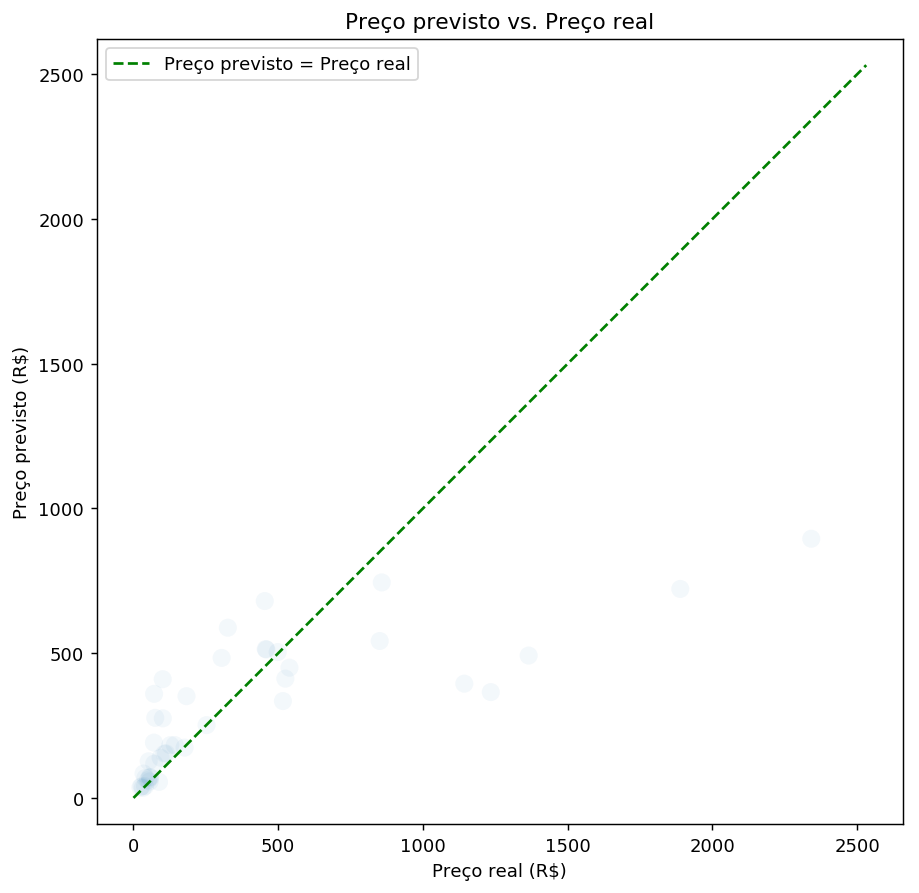

In [21]:
shared_functions.plot_predicted_vs_real_price(test_target, test_predictions, target)

### Mean absolute error

Now we can compare the errors obtained by our predictions against the errors provided by the baseline (average price). Our prediction errors should be less than the baseline errors to consider the model successful.

In [25]:
errors, errors_baseline, errors_relative, errors_baseline_relative = shared_functions.print_mean_absolute_error(test_predictions, test_target, average_target)

== Absolute
('Mean absolute prediction error: R$', 202.0)
('Std prediction error: R$', 325.54)
('Mean absolute error using average: R$', 342.05)
('Std prediction error using average: R$', 400.69)
== Relative
('Mean relative absolute prediction error: ', 0.69)
('Std relative prediction error: ', 0.84)
('Mean relative absolute error using average: ', 2.47)
('Std relative prediction error using average: ', 2.63)


### Join data

In [26]:
pd.set_option('display.max_columns', None)
data = {
    "all_features": test_features.tolist(),
    "sha256_id": test_features[:, 0],
    "target": test_target,
    "prediction": test_predictions,
    "error": errors,
    "error_relative": errors_relative,
    "error_baseline": errors_baseline,
    "error_baseline_relative": errors_baseline_relative
}
predicted_df = pd.DataFrame(data = data)
joined_predicted_df = predicted_df
joined_predicted_df = predicted_df.set_index("sha256_id").join(df.set_index("sha256_id"))

### Worst absolute predictions

Below we can inspect the rows with the biggest prediction error.

In [ ]:
joined_predicted_df.sort_values('error', ascending = False).head(20)

### Worst relative predictions

In [ ]:
joined_predicted_df.sort_values('error_relative', ascending = False).head(20)

### Best absolute predictions

In [ ]:
joined_predicted_df.sort_values('error', ascending = True).head(20)

### Best relative predictions

In [ ]:
joined_predicted_df.sort_values('error', ascending = True).head(20)

### Relative errors distribution

In [ ]:
centers, normalized_hist_predicted, normalized_hist_baseline = shared_functions.plot_relative_error_distribution(predicted_df)

#### Accumulated

In [ ]:
shared_functions.plot_accumulated_relative_error(centers, normalized_hist_predicted, normalized_hist_baseline)

### Joined data summary

In [ ]:
predicted_df.describe(percentiles=[0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99])

### Visualize decision tree

In [ ]:
# Pull out one tree from the forest
tree = rf.estimators_[0]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot',
                feature_names = feature_list, rounded = True)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

<img src="files/image.png">